In [ ]:
!pip intsall wfdb

ERROR: unknown command "intsall" - maybe you meant "install"


In [ ]:
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import json
# %matplotlib inline    

# <font size = 3> API Key for AAL data is: 0QMTOMP77P89LZHU

In [ ]:
symbol = '0QMTOMP77P89LZHU'

In [ ]:
from urllib.request import urlretrieve
import os.path

def read_data(file_path, feature_names, target_classes):
    total_columns = feature_names + target_classes
    data = pd.read_csv(file_path, names = total_columns)
    return data

def extract_to_folder(url, file_path):  
    ''' url: archieved data url (string)
        feature_names: feature names (list)
        target_classes: target (list)'''
    if not os.path.isfile(file_path):
        urlretrieve(url, file_path)
        print('data is extracted to folder: {}'.format(file_path))

In [ ]:
api_key = '0QMTOMP77P89LZHU'

# American Airlines stock market prices
ticker = "AAL"

In [ ]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
file_path = 'D:\Data analysis\__results___files'
feat_names = ['Date','Low','High','Close','Open']
target_names = []
extract_to_folder(url, file_path)

data is extracted to folder: D:\Data analysis\__results___files


In [ ]:
data = json.load(open(file_path, 'r'))
# extract stock market data
data = data['Time Series (Daily)']

In [ ]:
import datetime as dt
df = pd.DataFrame(columns=['date','open','high','low','close','volume'])
for k,v in data.items():
    date = dt.datetime.strptime(k, '%Y-%m-%d')
    data_row = [date.date(),float(v['1. open']),float(v['2. high']),
                float(v['3. low']),float(v['4. close']), float(v['5. volume'])]
    df.loc[-1,:] = data_row
    df.index = df.index + 1
# print('Data saved to : %s'%file_to_save)        
# df.to_csv(file_to_save)

In [ ]:
df.head(5)

,date,open,high,low,close,volume
3972,2021-07-09,20.79,21,20.5,20.89,2.17309e+07
3971,2021-07-08,19.88,20.64,19.655,20.35,2.85393e+07
3970,2021-07-07,20.79,21.05,20.17,20.31,3.0857e+07
3969,2021-07-06,21.5,21.79,20.86,21.01,2.41765e+07
3968,2021-07-02,21.615,21.65,21.11,21.48,2.08679e+07


# <font size = 2> Note: data in pandas has shown from index end to start which is in opposite manner.

In [ ]:
stk_data = df.drop(["date","volume"], axis = 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_scalar = MinMaxScaler()
stk_norm_data = mm_scalar.fit_transform(stk_data)

stk_norm_data =stk_data.to_numpy()/min_max
stk_norm_data =stk_norm_data.astype('float32')

In [ ]:
stk_norm_data

array([[0.31170964, 0.30976486, 0.31461602, 0.31263278],
       [0.29676466, 0.30388635, 0.30066061, 0.30380781],
       [0.31170964, 0.31058132, 0.30916598, 0.30315411],
       ...,
       [0.30530465, 0.3029066 , 0.30800991, 0.30151986],
       [0.28723928, 0.30209014, 0.29314616, 0.30625919],
       [0.31597964, 0.31629654, 0.29149463, 0.28664815]])

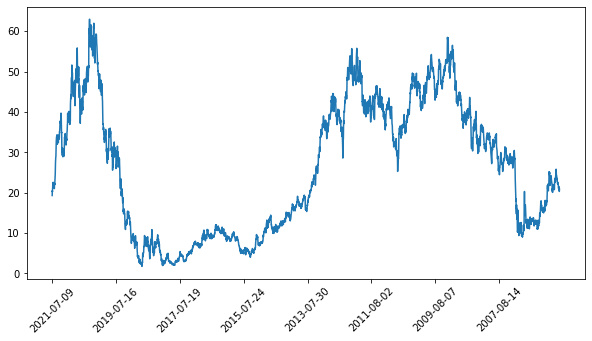

In [ ]:
plt.figure(figsize = (10,5))
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.plot(stk_data['close'])

Text(0.5, 1.0, 'stock close values')

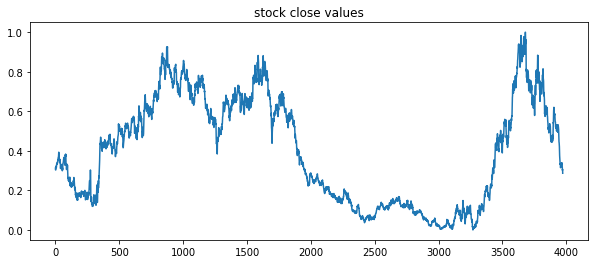

In [ ]:
close_stk_values = np.array([stk_norm_data[i, 3] for i in range(len(stk_data))])
plt.figure(figsize = (10,4))
plt.plot(close_stk_values)
plt.title("stock close values")

# <font size = 2> Note: Here data is plotted in correct manner in sequence. We consider this as the final sequence.

In [ ]:
print(np.shape(stk_norm_data))
print(stk_norm_data[0])

(3973, 4)
[0.31170964 0.30976486 0.31461602 0.31263278]


In [ ]:
# data preparation for LSTM.
# since we are using LSTM we need to look at timesteps (here we choose it to be 10)
# shape of input must be in the form of (no. of samples, time steps, length, width, channels)--> (3973-10+1, 10, 4, 1, 1)
def batch_collect1(stk_norm_data, time_steps):
    num_samples = len(stk_norm_data) - time_steps + 1 - 5
    data_samples = np.zeros((1,10,4), dtype = float)
    data_preds = np.zeros((1,5,1), dtype = float)
    for i in range(num_samples):
        strt_ind = i
        end_ind = i + 10
        x = stk_norm_data[strt_ind,:].reshape(1,4)
        y = stk_norm_data[end_ind][0].reshape(1,1)
        for j in range(strt_ind+1, end_ind):
            x = np.vstack((x, stk_norm_data[j,:].reshape(1,4)))
        for k in range(end_ind+1, end_ind + 5):
            y = np.vstack((y, stk_norm_data[k][0].reshape(1,1)))
        data_samples = np.vstack((data_samples, x.reshape(1,10,4)))
        data_preds = np.vstack((data_preds, y.reshape(1,5,1)))
    return data_samples, data_preds

In [ ]:
total_data1, total_labels1 = batch_collect1(stk_norm_data, 10)

In [ ]:
total_data1.shape,total_labels1.shape

((3960, 10, 4), (3960, 5, 1))

# <font size = 3> LSTM for prediction of forecoming 10th to 15th day stock openings:

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, TimeDistributed
from tensorflow.keras.layers import Flatten, Dense, Activation, LSTM
from keras.utils import np_utils

In [ ]:
lstm_output_size = 5
model = tf.keras.models.Sequential()
inputs = tf.keras.Input(shape = (10,4))
# ConvLayer1 = tf.keras.layers.Conv2D(2, kernel_size = (2,20), activation = 'relu', input_shape = (3,2,250,1), data_format = 'channels_last',name = 'ConvLayer1')
# lstmConv = tf.keras.layers.TimeDistributed(ConvLayer1, name = 'ConvLSTM')(inputs)
# FlattenLayer = tf.keras.layers.Flatten(name = 'FlattenLayer')
# lstmFlatten = tf.keras.layers.TimeDistributed(FlattenLayer, name = 'FlattenLSTM')(FlattenLayer)
# FlatOp = tf.keras.layers.TimeDistributed(FlattenLayer, name = 'lstmFlatten')(lstmConv)
lstmOp= tf.keras.layers.LSTM(lstm_output_size, return_sequences = False, name = 'LSTM_layer')(inputs) 
predictions = tf.keras.layers.Dense(5, activation = 'relu', name = 'FullyConnectedLayer')(lstmOp)
model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 5)                 200       
_________________________________________________________________
FullyConnectedLayer (Dense)  (None, 5)                 30        
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, x_test = total_data1[1:3000], total_data1[3000:]
y_train, y_test = total_labels1[1:3000], total_labels1[3000:] 

In [ ]:
history = model.fit(x_train, y_train, epochs = 5, batch_size = 50, verbose = True)

Epoch 1/5
60/60 [==============================] - 2s 5ms/step - loss: 0.0668
Epoch 2/5
60/60 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 3/5
60/60 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 4/5
60/60 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 5/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0025


In [ ]:
y_train_pred1 = model.predict(x_train)
y_train_pred1[0]

array([0.3118158, 0.3123982, 0.3261188, 0.3430835, 0.2972015],
      dtype=float32)

In [ ]:
y_train_pred1

array([[0.3118158 , 0.3123982 , 0.3261188 , 0.3430835 , 0.2972015 ],
       [0.31643164, 0.31695402, 0.3300444 , 0.34743392, 0.30223668],
       [0.31693605, 0.3183745 , 0.33225936, 0.34935045, 0.30456308],
       ...,
       [0.04657076, 0.01289435, 0.12033175, 0.05455455, 0.        ],
       [0.04715326, 0.013207  , 0.12066748, 0.05451025, 0.        ],
       [0.04695953, 0.01302103, 0.1206068 , 0.05445531, 0.        ]],
      dtype=float32)

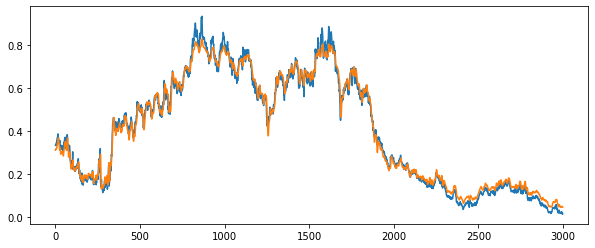

In [ ]:
y_train_pred = model.predict(x_train)
train_pred=[y_train_pred[i][0] for i in range(len(y_train_pred))]
train=[y_train[i][0] for i in range(len(y_train_pred))]
plt.figure(figsize = (10,4))
plt.plot(train, label = "actual")
plt.plot(train_pred, label = "predicted")

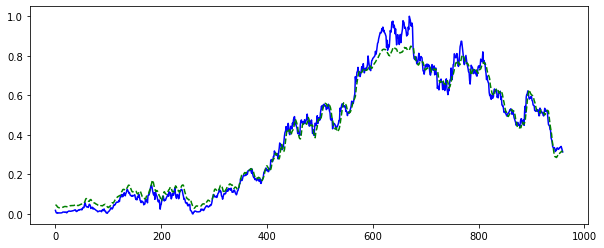

In [ ]:
y_test_pred = model.predict(x_test)
t_pred=[y_test_pred[i][0] for i in range(len(y_test_pred))]
test=[y_test[i][0] for i in range(len(y_test_pred))]
plt.figure(figsize = (10,4))
plt.plot(test, 'b-')
plt.plot(t_pred, 'g--')

In [ ]:
y_test_pred=pd.DataFrame(y_test_pred )
y_test=pd.DataFrame(y_test)
df_polarity_pred = pd.DataFrame()
df_polarity_test = pd.DataFrame()
for i in range(y_test_pred.shape[1]-1):
  df_polarity_pred[str(i)]=(y_test_pred[i]-y_test_pred[i+1])
  df_polarity_test[str(i)]=(y_test[i]-y_test[i+1])


In [ ]:
for i in df_polarity.columns:
  df_polarity_pred[i]=df_polarity_pred[i].apply(lambda x: 1 if(x>=0) else -1)
  df_polarity_test[i]=df_polarity_test[i].apply(lambda x: 1 if(x>=0) else -1)

In [ ]:
    for idx, _tag in enumerate(df_polarity_pred):
            tag_precision = metrics.precision_score(
                test_labels.values[:, idx], [:, idx],zero_division=0
            )
            tag_recall = metrics.recall_score(
                test_labels.values[:, idx], predicted[:, idx],zero_division=0
            )
            
           
            print(f"Tag: {_tag}")
            print(
                f"Precision: {tag_precision:.2f}."
                f" Recall: {tag_recall:.2f}"
            )

NameError: ignored